![](https://li5.cdbcdn.com/oh/621d843f-869f-4cbb-899e-2f9d31b9cabc.png?f=32&nocache=1)
# Predict TripAdvisor Rating
## В этом соревновании нам предстоит предсказать рейтинг ресторана в TripAdvisor

### Задание:
***Необходимо предсказать рейтинг ресторана в TripAdvisor***  

Одна из проблем компании TripAdvisor — это нечестные рестораны, которые накручивают себе рейтинг. Одним из способов нахождения таких ресторанов является построение модели, которая предсказывает рейтинг ресторана. Если предсказания модели сильно отличаются от фактического результата, то, возможно, ресторан играет нечестно, и его стоит проверить.

### Описание признаков
* Restaurant_id — идентификационный номер ресторана / сети ресторанов;
* City — город, в котором находится ресторан;
* Cuisine Style — кухня или кухни, к которым можно отнести блюда, предлагаемые в ресторане;
* Ranking — место, которое занимает данный ресторан среди всех ресторанов своего города;
* Rating — рейтинг ресторана по данным TripAdvisor (именно это значение должна будет предсказывать модель);
* Price Range — диапазон цен в ресторане;
* Number of Reviews — количество отзывов о ресторане;
* Reviews — данные о двух отзывах, которые отображаются на сайте ресторана;
* URL_TA — URL страницы ресторана на TripAdvisor;
* ID_TA — идентификатор ресторана в базе данных TripAdvisor.

# import

In [1]:
import warnings
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import collections
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:

warnings.simplefilter('ignore')

In [2]:
# фиксируем RANDOM_SEED, чтобы наши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# FUNCTIONS

In [4]:
#Вспомогательные функции, которые помогут в дальнейшей работе

# Функция для расчета и визуализации границ выбросов.

def IQR_indicator(df, column_name, bins_n=10):
    """ 
       Функция для расчета и визуализации границ выбросов.
       На ВХОДЕ: принимает название датафрейма, наименование столбца и количество столбиков гистограмы
       
       На ВЫХОДЕ: расчитанные параметры квартилей, гистограмма распределения, а также боксплот(boxplot)
    """
    df_column = df[column_name]
    perc_25 = df_column.quantile(0.25, interpolation="midpoint")
    perc_75 = df_column.quantile(0.75, interpolation="midpoint")
    IQR = perc_75 - perc_25
    print(f'25-й перцентиль(Q1): {perc_25}\n75-й перцентиль(Q3): {perc_75}\nIQR: {IQR}',
          f'\nГраницы выбросов: [{perc_25 - 1.5*IQR}, {perc_75 + 1.5*IQR}]')
    
    # гистограмма распределения: 
    plt.figure(figsize=(15, 5))
    plt.subplot(121)
    sns.distplot(df_column.values, bins=bins_n, color='crimson')
    plt.title(column_name + ' - Распределение\n', fontsize=15)
    plt.xlabel(column_name)
    plt.ylabel('Количество (Частота)')

    # boxplot: 
    plt.subplot(122)
    sns.boxplot(df_column.values, color='#6495ED')
    plt.title(column_name + ' - Распределение\n', fontsize=15)
    plt.xlabel(column_name)
    return 0



# DATA

In [5]:
df_train = pd.read_csv('main_task.csv')
df_test = pd.read_csv('kaggle_task.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      40000 non-null  object 
 1   City               40000 non-null  object 
 2   Cuisine Style      30717 non-null  object 
 3   Ranking            40000 non-null  float64
 4   Rating             40000 non-null  float64
 5   Price Range        26114 non-null  object 
 6   Number of Reviews  37457 non-null  float64
 7   Reviews            40000 non-null  object 
 8   URL_TA             40000 non-null  object 
 9   ID_TA              40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [7]:
df_train.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


In [8]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      10000 non-null  object 
 1   City               10000 non-null  object 
 2   Cuisine Style      7693 non-null   object 
 3   Ranking            10000 non-null  float64
 4   Price Range        6525 non-null   object 
 5   Number of Reviews  9343 non-null   float64
 6   Reviews            9998 non-null   object 
 7   URL_TA             10000 non-null  object 
 8   ID_TA              10000 non-null  object 
dtypes: float64(2), object(7)
memory usage: 703.2+ KB


In [9]:
df_test.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354


In [10]:
sample_submission.head(5)

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0


In [11]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Restaurant_id  10000 non-null  object 
 1   Rating         10000 non-null  float64
dtypes: float64(1), object(1)
memory usage: 156.4+ KB


Дря корректной обработки признаков объединяем трейн и тест в один датасет

In [12]:
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   City               50000 non-null  object 
 2   Cuisine Style      38410 non-null  object 
 3   Ranking            50000 non-null  float64
 4   Price Range        32639 non-null  object 
 5   Number of Reviews  46800 non-null  float64
 6   Reviews            49998 non-null  object 
 7   URL_TA             50000 non-null  object 
 8   ID_TA              50000 non-null  object 
 9   sample             50000 non-null  int64  
 10  Rating             50000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


In [14]:
data.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
47612,id_3432,Paris,['Chinese'],3433.0,$$ - $$$,40.0,"[['Very good Chinese restaurant in Paris.', 'G...",/Restaurant_Review-g187147-d9468440-Reviews-JI...,d9468440,1,4.5
5985,id_5985,Milan,NaN,4551.0,NaN,2.0,"[[], []]",/Restaurant_Review-g187849-d8261973-Reviews-Do...,d8261973,0,0.0
20904,id_1840,Lisbon,NaN,1843.0,NaN,3.0,"[['Awesome Beef Sandwiches'], ['02/20/2017']]",/Restaurant_Review-g189158-d12173633-Reviews-R...,d12173633,1,5.0
2034,id_2034,Hamburg,"['Italian', 'Mediterranean', 'European', 'Seaf...",737.0,$$ - $$$,59.0,"[['Worlds best truffel pasta?', 'Excellent and...",/Restaurant_Review-g187331-d1909700-Reviews-Po...,d1909700,0,0.0
25334,id_2318,Lisbon,"['European', 'Portuguese']",2321.0,$,9.0,"[['Walnut Cake!', 'Very cozy place!'], ['06/11...",/Restaurant_Review-g189158-d7787431-Reviews-Bo...,d7787431,1,4.5


В объединенном наборе данных 10 первоначальных признаков и искусственный признак 'sample' для дальнейшего разделения датасета на тестовый и тренировочный). Три признака содержат числовые значениям, остальные - номинативы. Далее проведем более детальный анализ этих данных.


![.](https://3.downloader.disk.yandex.ru/preview/2a65d251d5659b3a4179e29c3b82873ea8cc5750d1307dc1e313cf79c1b8a1f8/inf/fb7Yx6j_KJ5azHw9dLVeywAIxGfYqQh3Qw9OOO8n35JBjZxApNfam0f7DSD6zj_uDFczAzmambvZU7DfqCFlHw%3D%3D?uid=1150941350&filename=EDA.jpg&disposition=inline&hash=&limit=0&content_type=image%2Fjpeg&owner_uid=1150941350&tknv=v2&size=1903x928)
# EDA

**Exploratory Data Analysis** - Разведывательный анализ данных  
На этом этапе мы строим графики, ищем закономерности, аномалии, выбросы или связи между признаками.
В общем цель этого этапа понять, что эти данные могут нам дать и как признаки могут быть взаимосвязаны между собой.
Понимание изначальных признаков позволит сгенерировать новые, более сильные и, тем самым, сделать нашу модель лучше.


### ПРОПУСКИ  
Посмотрим на количество пропусков в колонках, в каких есть и сколько

In [15]:
for col in data.columns:
    percnt_missing = np.mean(data[col].isnull())
    print(f'{col} - {round(percnt_missing*100)}%')

Restaurant_id - 0%
City - 0%
Cuisine Style - 23%
Ranking - 0%
Price Range - 35%
Number of Reviews - 6%
Reviews - 0%
URL_TA - 0%
ID_TA - 0%
sample - 0%
Rating - 0%


***Промежуточные выводы:***  
- Датасет содержит 50 000 строк и 10 колонок (за исключением **sample**)
- Пропуски есть в колонке **Cuisine Style** в размере 23%
- Пропущенные значения также присутствуют в колонке **Price Range** - это 35%
- Небольшая часть данных, в размере 6% пропущена в колонке **Number of Reviews**  
- На первый взгляд колонка **Reviews** не содержит отзывы, однако если визуально ее просомтреть, то есть такие значения: '[[],[]], что юезусловно тоже является пропуском (иначе говоря пустой отзыв)



### RATING
Начнем с распределения целевой переменной Rating

In [16]:
df_train['Rating'].describe()

count    40000.000000
mean         3.993037
std          0.668417
min          1.000000
25%          3.500000
50%          4.000000
75%          4.500000
max          5.000000
Name: Rating, dtype: float64

25-й перцентиль(Q1): 3.5
75-й перцентиль(Q3): 4.5
IQR: 1.0 
Границы выбросов: [2.0, 6.0]


0

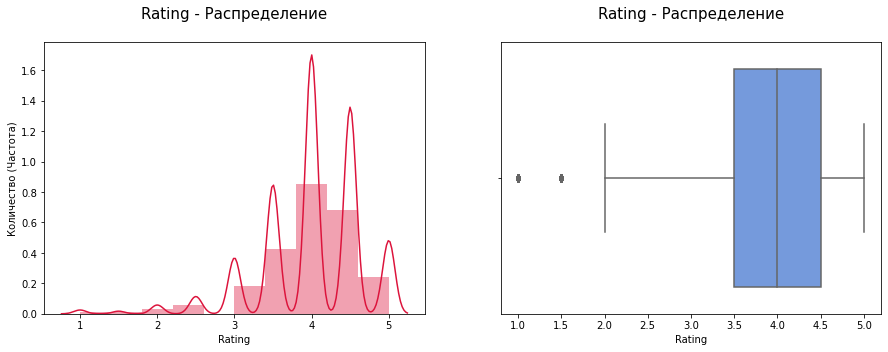

In [17]:
IQR_indicator(df_train, 'Rating', 10) 

**Промежуточные выводы:**

- Целевая переменная имеет нормальное распределение, сдвинутое вправо, от 1 до 5.
- Первый квартиль 3.5
- Третий квартиль 4.5
- Среднее знчение 4.0 (в округлении)
- Выбросы имеются

### RESTAURANT_ID 

In [18]:
print(f'Уникальное количество ID в колонке : {data.Restaurant_id.nunique()}')
data['Restaurant_id'].value_counts()

Уникальное количество ID в колонке : 13094


id_633      19
id_227      19
id_871      19
id_436      19
id_321      18
            ..
id_13468     1
id_6851      1
id_13028     1
id_8502      1
id_10215     1
Name: Restaurant_id, Length: 13094, dtype: int64

Возникает отщущение, что в датасете присутствуют сетевые рестораны, или несколько ресторанов одного владельца...

### CITY

In [19]:
data.City.unique()

array(['Paris', 'Helsinki', 'Edinburgh', 'London', 'Bratislava', 'Lisbon',
       'Budapest', 'Stockholm', 'Rome', 'Milan', 'Munich', 'Hamburg',
       'Prague', 'Vienna', 'Dublin', 'Barcelona', 'Brussels', 'Madrid',
       'Oslo', 'Amsterdam', 'Berlin', 'Lyon', 'Athens', 'Warsaw',
       'Oporto', 'Krakow', 'Copenhagen', 'Luxembourg', 'Zurich', 'Geneva',
       'Ljubljana'], dtype=object)

Общее количество городов в датасете: 31


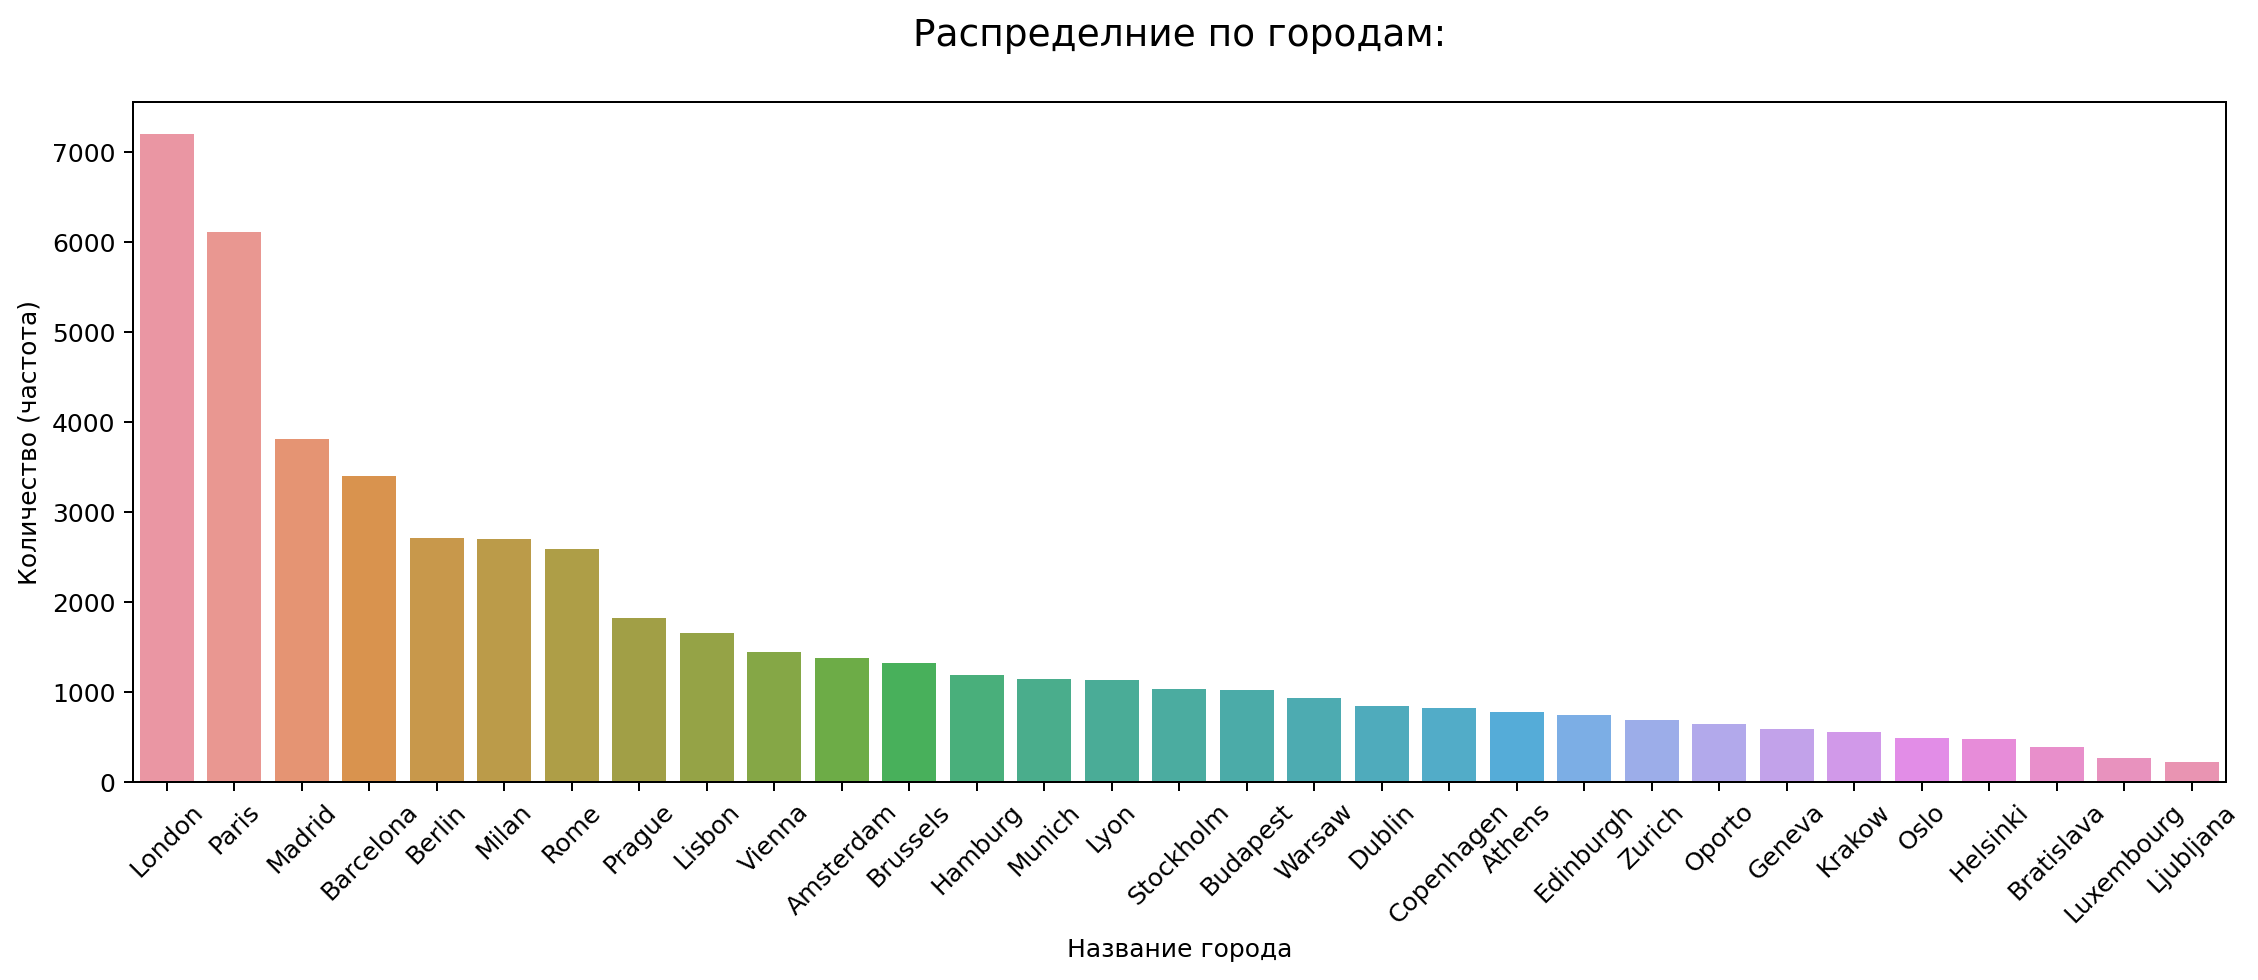

In [20]:
plt.figure(figsize=(15, 5), dpi=180)
sns.countplot(data['City'], order=data['City'].value_counts().index)
plt.xticks(rotation=45)
plt.title('Распределние по городам:\n', fontsize=15)
plt.xlabel('Название города')
plt.ylabel('Количество (частота)')

print(f'Общее количество городов в датасете: {data.City.nunique()}')

***Промежуточные выводы:***

- Больше всего любителей поесть проживает в Лондоне, затем в Париже, Мадриде и Барселоне
- В датасете не представлены Российские города, все города европейские
- Город Опорто не существует, зато существует такое название ресторанов на франчайзенговой основе, австралийский фастфуд на португальскую тематику
- Можно предположить, что все-таки имелся ввиду город Порту (Porto)


In [21]:
# заменим название Опорто на Порту
data['City'] = data['City'].replace(['Oporto'], 'Porto')

Создадим новый признак (rst_counts) - количество ресторанов в городе:

In [22]:
city_counts_dct = dict(data['City'].value_counts())
data['rst_counts'] = data.City.map(city_counts_dct)

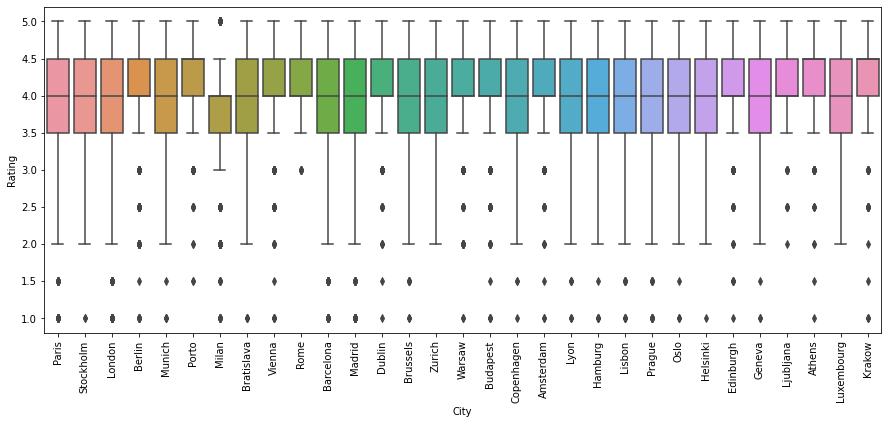

In [23]:
plt.figure(figsize=(15, 6))
sns.boxplot(x='City', y='Rating', data=data[data['sample'] == 1])
plt.xticks(rotation=90);

В Милане, как оказалось, рейтинги низковатые, по сравнению с остальными городами, хотя и есть выброс с рейтингом в 5 баллов. А в Риме меньше всего выбросов и колеблятся они с 3.

### CUISINE_STYLE

In [24]:
type(data['Cuisine Style'][0])

str

In [25]:
data['Cuisine Style'].sample(5)

43771                                                  NaN
39274                                         ['European']
34159                                                  NaN
34116        ['French', 'European', 'Vegetarian Friendly']
32000    ['French', 'Brazilian', 'Mediterranean', 'Euro...
Name: Cuisine Style, dtype: object

In [26]:
data['Cuisine Style'].isnull().sum()

11590

***Промежуточные выводы:*** 
- Вот они, те самые 23% пропусков - в лице 11 590 значений
- Необходимо эти пустые значения вынести в отдельный признак **cuisine_style_is_NAN**
- Заменим тип кухни у этих пустых значений на **other**
- Далее посмотрим сколько же в итоге образовалось уникальных кухонь
- Последующие измнения, в случае чего, произведем в следующем разделе (если потребуется)

In [27]:
# Записываем в новую колонку пустые значения
data['cuisine_style_is_NAN'] = pd.isna(data['Cuisine Style']).astype('uint8')

In [28]:
data['Cuisine Style'] = data['Cuisine Style'].fillna("['Other']")

In [29]:
# преобразуем строку в список кухонь для удобства последующей работы
data['Cuisine Style'] = data['Cuisine Style'].apply(lambda x: eval(x))

Добавим новый признак **cuisines_counts** обозначающий количество кухонь в ресторане:

In [30]:
data['cuisines_counts'] = data['Cuisine Style'].apply(lambda x: len(x))

In [31]:
# Посмотрим теперь на самые популярные
data['Cuisine Style'].explode().value_counts(ascending=False)

Vegetarian Friendly    14021
European               12561
Other                  11590
Mediterranean           7820
Italian                 7433
                       ...  
Yunnan                     2
Xinjiang                   1
Latvian                    1
Burmese                    1
Salvadoran                 1
Name: Cuisine Style, Length: 126, dtype: int64

В итоге самая популярная кухня это *Vegetarian Friendly*   
Для пущей наглядности попробуем выделить самые популярные (встречающиеся) кухни и самые редкие:

In [32]:
group_city_cuisine = data.groupby(
    ['City'])['Cuisine Style'].sum().reset_index()

In [33]:
#С помощью счетчика, произведем рассчеты 10-ти самых редко встречающихся 
#и 10-ти самых часто встречающихся кухонь в ресторанах

c = collections.Counter()

for cuisine_style in group_city_cuisine['Cuisine Style']:
    for x in cuisine_style:
        c[x] += 1

print(c.most_common(10), "\n\n", c.most_common()[-10:])

[('Vegetarian Friendly', 14021), ('European', 12561), ('Other', 11590), ('Mediterranean', 7820), ('Italian', 7433), ('Vegan Options', 5684), ('Gluten Free Options', 5185), ('Bar', 4094), ('French', 3970), ('Asian', 3786)] 

 [('Caucasian', 4), ('Azerbaijani', 3), ('Welsh', 3), ('Yunnan', 2), ('Polynesian', 2), ('Fujian', 2), ('Latvian', 1), ('Burmese', 1), ('Salvadoran', 1), ('Xinjiang', 1)]


Запишем их в новые переменные **top_common_cui** и **top_unique_cui:**

In [34]:
#Определяем 10 самых ЧАСТО встречающихся кухонь в ресторанах и записываем их в новую переменную

top_common_cui = []
top_common_cui = data.explode('Cuisine Style')['Cuisine Style'].value_counts()[
    data.explode('Cuisine Style')['Cuisine Style'].value_counts() >= 3786].index.tolist()


def most_common_func(column):
    x = 0
    for i in top_common_cui:
        if i in column:
            x += 1
    return x


data['most_common_cuisine'] = data['Cuisine Style'].apply(most_common_func)

In [35]:
#Определяем 10 самых РЕДКО встречающихся кухонь в ресторанах и записываем их в новую переменную

top_unique_cui = []
top_unique_cui = data.explode('Cuisine Style')['Cuisine Style'].value_counts()[
    data.explode('Cuisine Style')['Cuisine Style'].value_counts() <= 4].index.tolist()


def most_unique_func(column):
    x = 0
    for i in top_unique_cui:
        if i in column:
            x += 1
    return x


data['top_unique_cuisine'] = data['Cuisine Style'].apply(most_unique_func)

### RANKING

Text(0.5, 0, 'Ranking')

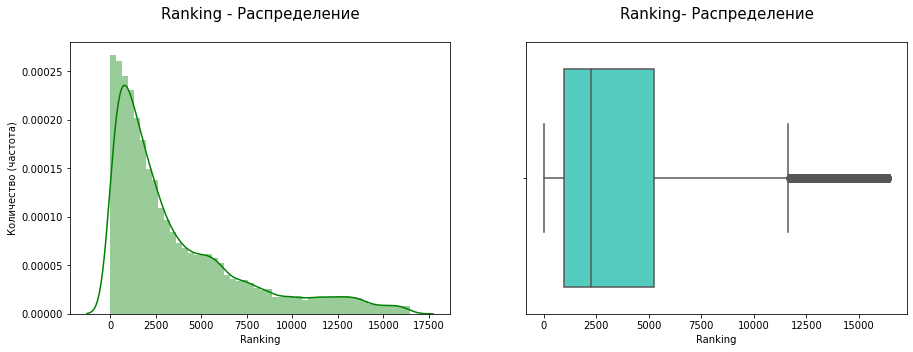

In [36]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
sns.distplot(data.Ranking.values, bins=50, color='green')
plt.title('Ranking - Распределение\n', fontsize=15)
plt.xlabel('Ranking')
plt.ylabel('Количество (частота)')

plt.subplot(122)
sns.boxplot(data.Ranking.values, color='Turquoise')
plt.title('Ranking- Распределение\n', fontsize=15)
plt.xlabel('Ranking')

In [37]:
data.Ranking.describe()

count    50000.000000
mean      3664.427520
std       3700.092452
min          1.000000
25%        972.000000
50%       2278.000000
75%       5241.000000
max      16444.000000
Name: Ranking, dtype: float64

Распределение смещено влево, от 1 до 16 444, медиана 2 278, первый и третий квартили находятся в диапазоне от 972 до 5 241 соответственно.
Исходя из описания признака по заданию, эта колонка представляет собой  место в рейтинге, которое ресторан занимает среди всех ресторанов в городе, поэтому рассматривать его надо совместно с городами. Разделим Ranking на количество ресторанов в городе:

In [38]:
data['ranking_nrm'] = data.Ranking / data.rst_counts

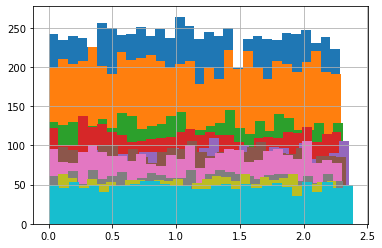

In [39]:
for x in (data['City'].value_counts())[0:10].index:
    data['ranking_nrm'][data['City'] == x].hist(bins=30)

<AxesSubplot:>

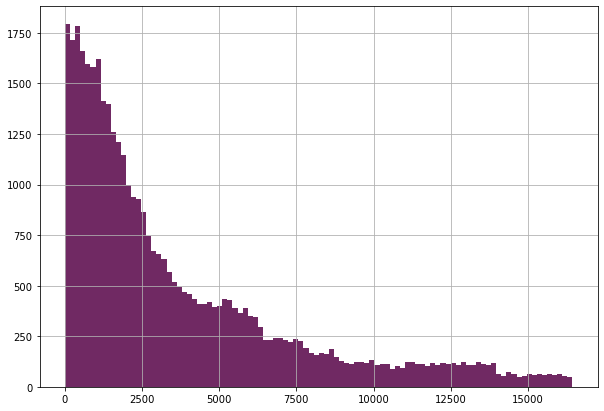

In [40]:
plt.rcParams['figure.figsize'] = (10,7)
df_train['Ranking'].hist(bins=100, color='#702963')

Достаточно много ресторанов, которые не дотягивают и до 2500 места в своем городе, а что там по городам?
Помнится, смотрели на графике, что лидировал Лондон, затем шли Париж, мадрид и Барселона.
Взглянем еще разок и отдельно посмотрим показатели Лондона:

<AxesSubplot:>

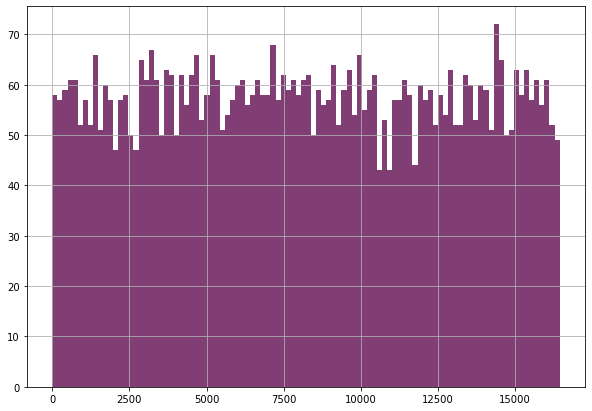

In [41]:
df_train['Ranking'][df_train['City'] =='London'].hist(bins=100, color= '#803e75')

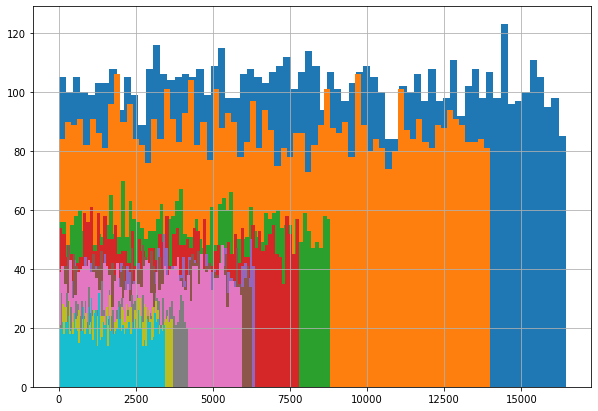

In [42]:
# Посмотрим на топ 10 городов и рейтинг

for x in (data['City'].value_counts())[0:10].index:
    data['Ranking'][data['City'] == x].hist(bins=70)
plt.show()

Распределение у признака *Ranking* нормальное, смещение по причине того, что в больших городах больше ресторанов

### PRICE RANGE

In [43]:
data['Price Range'].value_counts(dropna=False)

$$ - $$$    23041
NaN         17361
$            7816
$$$$         1782
Name: Price Range, dtype: int64

Условно обозначается количестом символа - доллар, чем их больше, тем ресторан дороже. Такой формат наша модель не примет, имеет смысл заменить и плюс ко всему, как мы помним, в этой колонке у нас 35% пропусков.

Часто встречающееся значение: 

In [44]:
data['Price Range'].mode()

0    $$ - $$$
dtype: object

Заменим пропуски модой:

In [45]:
data['Price Range'].fillna(data['Price Range'].mode()[0], inplace=True)

Ранжируем признаки от 1 до 3:

In [46]:
price_dict = {'$': 1,
              '$$ - $$$': 2,
              '$$$$': 3}

data['Price Range'] = data['Price Range'].map(price_dict)

<AxesSubplot:xlabel='Price Range', ylabel='Rating'>

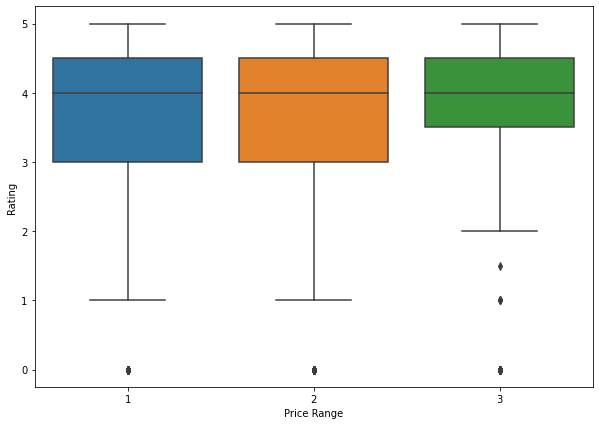

In [47]:
sns.boxplot(x='Price Range', y='Rating', data=data)

Как видно, самые дорогие рестораны получают низкие оценки реже, чем остальные.

### NUMBER OF REVIEWS:

In [48]:
data['Number of Reviews'].describe()

count    46800.000000
mean       124.471197
std        294.114345
min          2.000000
25%          9.000000
50%         33.000000
75%        115.000000
max       9660.000000
Name: Number of Reviews, dtype: float64

In [49]:
data['Number of Reviews'].isnull().sum()

3200

In [50]:
#Отложим в отдельную переменную 'Number_of_Reviews_isNAN' пустые значения
data['Number_of_Reviews_isNAN'] = pd.isna(
    data['Number of Reviews']).astype('uint8')
data['Number_of_Reviews_isNAN']

0        0
1        0
2        0
3        0
4        0
        ..
49995    0
49996    0
49997    0
49998    0
49999    0
Name: Number_of_Reviews_isNAN, Length: 50000, dtype: uint8

Поскольку у нас есть столбец *Reviews* и в нем могут быть значения, которые не отмечены в *Number of Reviews*,
то было бы логично их поместить в нашу колонку, хотя это и последние два отзыва,
но это все же лучше, чем заменить их нолями.
А вот оставшиеся пропуски заменим нолем.
Всего пропусков в колонке было 3 200, это может быть критично для модели

In [51]:
def number_of_reviews(row):
    if pd.isnull(row['Number of Reviews']):
        if row['Reviews'] is None:
            return 0
        return 1
    return row['Number of Reviews']


data['Number of Reviews'] = data.apply(number_of_reviews, axis=1)

In [52]:
#проверим что теперь в колонке
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Restaurant_id            50000 non-null  object 
 1   City                     50000 non-null  object 
 2   Cuisine Style            50000 non-null  object 
 3   Ranking                  50000 non-null  float64
 4   Price Range              50000 non-null  int64  
 5   Number of Reviews        50000 non-null  float64
 6   Reviews                  49998 non-null  object 
 7   URL_TA                   50000 non-null  object 
 8   ID_TA                    50000 non-null  object 
 9   sample                   50000 non-null  int64  
 10  Rating                   50000 non-null  float64
 11  rst_counts               50000 non-null  int64  
 12  cuisine_style_is_NAN     50000 non-null  uint8  
 13  cuisines_counts          50000 non-null  int64  
 14  most_common_cuisine   

Отлично, пропусков нет, теперь посмотрим на распределение признака и его возможные выбросы:

25-й перцентиль(Q1): 7.0
75-й перцентиль(Q3): 105.0
IQR: 98.0 
Границы выбросов: [-140.0, 252.0]


0

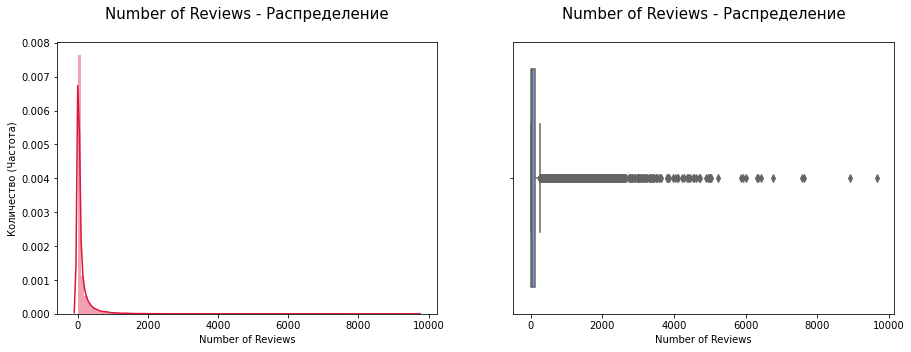

In [53]:
IQR_indicator(data, 'Number of Reviews', 100) 

Выбросы, конечно есть, посмотрим, сколько в количественном эквиваленте выбросов, превыщаюших порог третьего квартиля:
    

In [54]:
print(f'Кол-во выбросов, превыщающих верхнюю границу:', sum(data['Number of Reviews'] > 252))

Кол-во выбросов, превыщающих верхнюю границу: 5946


По распределению видно, что есть сильное смещение вправо и примерно после цифры 2 000 значений почти не видно в динамике, но они есть. Посомтрим сколько их:

In [55]:
print(f'Кол-во значений, содержащих более 2000 отзывов:', sum(data['Number of Reviews'] > 2000))

Кол-во значений, содержащих более 2000 отзывов: 171


Получается, что 171 значение мы обьединили под классификацией "свыше 2000 отзывов"

### REVIEWS

In [56]:
#Проверим количество пропусков

data['Reviews'].isnull().sum()

2

In [57]:
data['Reviews'].value_counts()

[[], []]                                                                                                        8112
[['Excellent'], ['09/03/2015']]                                                                                    2
[['Visited the rooftop bar', 'SIXTH FLOOR ROOFTOP BUT YOU CAN ONLY SEE O...'], ['06/27/2017', '10/31/2017']]       2
[['Excellent cuisine, friendly and helpful se...', 'Not tasty'], ['12/25/2016', '06/05/2016']]                     2
[['Great coffee and pastries, sandwiches, ver...', 'Great breakfast!'], ['02/21/2017', '09/19/2016']]              2
                                                                                                                ... 
[['Ripped off at this place - THIEVES!', 'Disgusting dinner'], ['11/18/2017', '11/07/2017']]                       1
[['cold and not tasty', 'Handy And Tasty'], ['10/14/2015', '03/18/2015']]                                          1
[['Delightful experience', 'very romantic garden for a dinner or

In [58]:
data['Reviews'].head(5)

0                                             [[], []]
1    [['Very good reviews!', 'Fine dining in Hakani...
2    [['Better than the Links', 'Ivy Black'], ['12/...
3    [['Most exquisite', 'Delicious and authentic']...
4    [['Always the best in bratislava', 'Very good ...
Name: Reviews, dtype: object

С признаком стоит поработать, есть пустые отзывы и 2 пропуска, а также подмешиваются даты в тексте.

### URL_TA

In [59]:
data.loc[data['URL_TA'][0]:3]

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,rst_counts,cuisine_style_is_NAN,cuisines_counts,most_common_cuisine,top_unique_cuisine,ranking_nrm,Number_of_Reviews_isNAN
0,id_0,Paris,"[Bar, Pub]",12963.0,2,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,6108,0,2,1,0,2.122299,0
1,id_1,Helsinki,"[European, Scandinavian, Gluten Free Options, ...",106.0,2,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,475,0,5,4,0,0.223158,0
2,id_2,Edinburgh,[Vegetarian Friendly],810.0,2,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0,745,0,1,1,0,1.087248,0
3,id_3,London,"[Italian, Mediterranean, European, Vegetarian ...",1669.0,3,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0,7193,0,5,5,0,0.232031,0


In [60]:
data['URL_TA'].head(3)

0    /Restaurant_Review-g187147-d10746918-Reviews-L...
1    /Restaurant_Review-g189934-d6674944-Reviews-Ra...
2    /Restaurant_Review-g186525-d13129638-Reviews-B...
Name: URL_TA, dtype: object

In [61]:
data['URL_TA'][0]

'/Restaurant_Review-g187147-d10746918-Reviews-Le_Perchoir-Paris_Ile_de_France.html'

В URL проглядываются и ID_TA наших ресторанов. Пока неизвестно как использовать информацию из данной колонки в рамках конкретного задания. Хотя в будущем, по этим данным можно уточнять, актуализировать и добавлять информацию в датасет.

### ID_TA

In [62]:
type(data['ID_TA'][0])

str

In [63]:
data['ID_TA'].head(5)

0    d10746918
1     d6674944
2    d13129638
3      d680417
4     d1112354
Name: ID_TA, dtype: object

Строковый тип, мы помним про то, что для модели нужны числовые данные, возможно, эта графа пригодится еще.
Превратим ее данные в числовые:

In [64]:
data['ID_TA'] = data['ID_TA'].apply(lambda x: int(x[1:]))

In [65]:
data['ID_TA'].value_counts()

2477531     2
11921719    2
3161682     2
793170      2
5617412     2
           ..
10396257    1
6845353     1
5263967     1
7291485     1
720896      1
Name: ID_TA, Length: 49963, dtype: int64

Похоже на наличие дубликатов, посколько у каждого ресторана свой идентификатор. 

In [66]:
print("Рестораны, идентификатор которых повторяется:", sum(data['ID_TA'].value_counts() > 1))

Рестораны, идентификатор которых повторяется: 37


### Посмотрим распределение целевой переменной:

<AxesSubplot:>

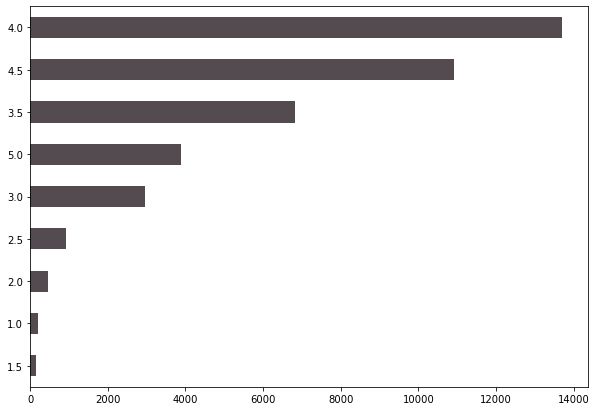

In [67]:
df_train['Rating'].value_counts(ascending=True).plot(kind='barh', color='#534b4f')

### Посмотрим распределение целевой переменной относительно признака рейтинга:

<AxesSubplot:>

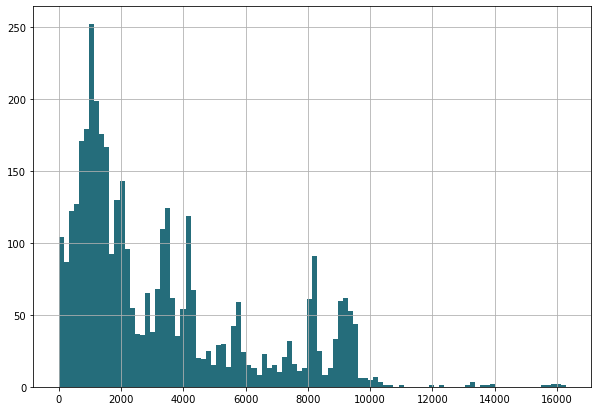

In [68]:
df_train['Ranking'][df_train['Rating'] == 5].hist(bins=100, color= '#256d7b')

<AxesSubplot:>

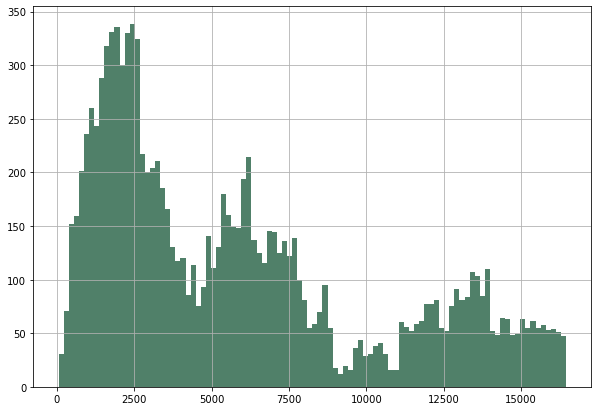

In [69]:
df_train['Ranking'][df_train['Rating'] < 4].hist(bins=100, color= '#508069')

### КОРРЕЛЯЦИЯ ПРИЗНАКОВ

<AxesSubplot:>

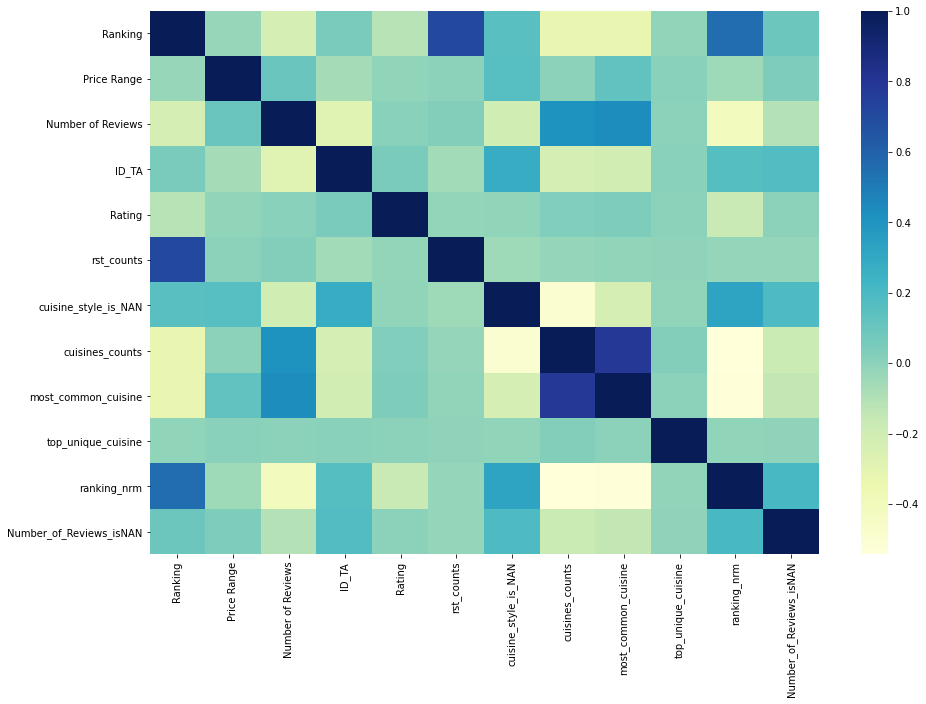

In [70]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.drop(['sample'], axis=1).corr(),cmap = 'YlGnBu')

# CLEANING and PREPPING DATA
Обычно данные содержат в себе кучу мусора, который необходимо почистить, для того чтобы привести их в приемлемый формат.  
Чистка данных — это необходимый этап решения почти любой реальной задачи.   


### Reviews: продолжим работу с признаком

In [71]:
data['Reviews_isNAN'] = pd.isna(data['Reviews']).astype('uint8')
data['Reviews_isNAN']

0        0
1        0
2        0
3        0
4        0
        ..
49995    0
49996    0
49997    0
49998    0
49999    0
Name: Reviews_isNAN, Length: 50000, dtype: uint8

In [72]:
data['Reviews'].head(5)

0                                             [[], []]
1    [['Very good reviews!', 'Fine dining in Hakani...
2    [['Better than the Links', 'Ivy Black'], ['12/...
3    [['Most exquisite', 'Delicious and authentic']...
4    [['Always the best in bratislava', 'Very good ...
Name: Reviews, dtype: object

Наблюдаем то, что признак состоит из отзыва в виде текста и даты.  
Также можно было заметить, что есть отзывы, в которых только скобки "[[], []]", то есть они пустые, а есть и 2 значения NaN.
Возможно, в этом есть какой-то смысл и пригодится для работы модели, поэтому вынесу их в отдельную переменную(значения, где пустой отзыв в скобках).

In [73]:
data['review_is_NAN'] = (data['Reviews'] == '[[], []]').astype('uint8')
data['review_is_NAN'] = pd.isna(data['Reviews']).astype('uint8')

Разобьем их на новые признаки и запишем разницу между датами публикаций отзывов:

*review_dt* - даты оставленных отзывов,
*difference_rev* - сюда запишем разницу в этих датах

In [74]:
data['review_dt'] = data['Reviews'].apply(
    lambda x: [0] if pd.isna(x) else x[2:-2].split('], [')[1][1:-1].split("', '"))
data['review_dt']

0                              []
1        [12/05/2017, 10/29/2017]
2        [12/28/2017, 12/06/2017]
3        [12/06/2017, 11/22/2017]
4        [02/08/2018, 01/24/2018]
                   ...           
49995    [12/16/2017, 11/12/2017]
49996    [12/21/2017, 12/12/2017]
49997    [11/03/2016, 04/12/2008]
49998    [07/11/2017, 06/18/2017]
49999    [01/31/2016, 07/04/2012]
Name: review_dt, Length: 50000, dtype: object

In [75]:
data['difference_rev'] = data.review_dt.apply(
    lambda x: None if x == [] else pd.to_datetime(x).max() - pd.to_datetime(x).min())

In [76]:
data['difference_rev'].describe()

count                          41888
mean     123 days 05:05:55.462184874
std      212 days 14:08:22.315988208
min                  0 days 00:00:00
25%                  8 days 00:00:00
50%                 49 days 00:00:00
75%                148 days 00:00:00
max               3296 days 00:00:00
Name: difference_rev, dtype: object

Максимальный интервал между отзывами: 3296 дней, это приблизительно 9 лет.  
Необходимо посмотреть распределение данного (нового теперь уже) признака и проверить выбросы.

In [77]:
data['difference_rev'] = data['difference_rev'].apply(lambda x: x.days)

25-й перцентиль(Q1): 8.0
75-й перцентиль(Q3): 148.0
IQR: 140.0 
Границы выбросов: [-202.0, 358.0]


0

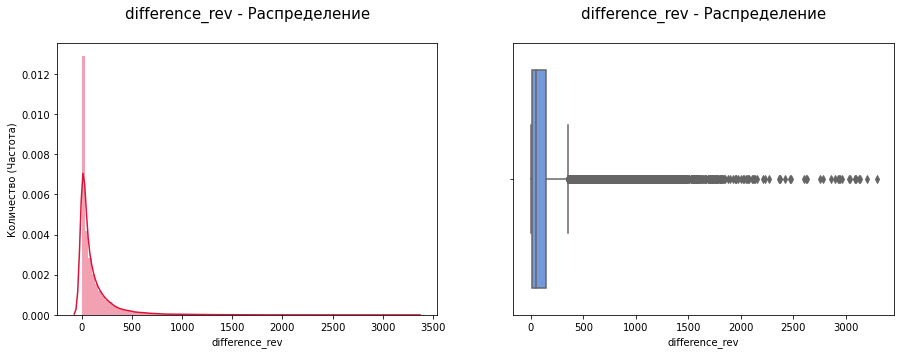

In [78]:
IQR_indicator(data, 'difference_rev', 100)

Видно, что распределение признака неравномерное, до 1000 (дней) его еще можно отследить на графике, после, почти не заметно, таким образом, значения свыше 1000 дней (3 года), можно учесть как отзывы, оставленные свыше 3х лет и не рассматривать по отдельности.

In [79]:
# Из рассчета: 3x365 = 1095

data.difference_rev = data.difference_rev.apply(lambda x: 1095 if x > 1095 else x)

In [80]:
print("Пропущенных значений в столбце:",data.difference_rev.isnull().sum())

Пропущенных значений в столбце: 8112


***Заполним пропуски медианным значением:***

In [81]:
data.difference_rev.describe()

count    41888.000000
mean       119.478180
std        185.985765
min          0.000000
25%          8.000000
50%         49.000000
75%        148.000000
max       1095.000000
Name: difference_rev, dtype: float64

In [82]:
data.difference_rev = data.difference_rev.fillna(data.difference_rev.median())

In [83]:
data['review_dt']

0                              []
1        [12/05/2017, 10/29/2017]
2        [12/28/2017, 12/06/2017]
3        [12/06/2017, 11/22/2017]
4        [02/08/2018, 01/24/2018]
                   ...           
49995    [12/16/2017, 11/12/2017]
49996    [12/21/2017, 12/12/2017]
49997    [11/03/2016, 04/12/2008]
49998    [07/11/2017, 06/18/2017]
49999    [01/31/2016, 07/04/2012]
Name: review_dt, Length: 50000, dtype: object

Вернемся к колонке **Restaurant_id**, помнится, там тоже были интересные показатели:

In [84]:
display(data['Restaurant_id'].value_counts(), sum(
    data['Restaurant_id'].value_counts() >= 2))

id_633      19
id_227      19
id_871      19
id_436      19
id_321      18
            ..
id_13468     1
id_6851      1
id_13028     1
id_8502      1
id_10215     1
Name: Restaurant_id, Length: 13094, dtype: int64

9287

Это больше похоже на сеть ресторанов, типа McDonald's или Starbucks

### CITY

In [85]:
#для One-Hot Encoding в pandas есть готовая функция - get_dummies. Особенно радует параметр dummy_na
data = pd.get_dummies(data, columns=[ 'City',], dummy_na=True)

In [86]:
data.drop(['sample'], axis=1).corr().Rating.sort_values(ascending=False).to_frame()

,Rating
Rating,1.000000
ID_TA,0.049589
most_common_cuisine,0.036152
cuisines_counts,0.034506
City_Rome,0.027527
City_Athens,0.016852
City_Berlin,0.012834
Number of Reviews,0.011006
City_Vienna,0.010188
City_Porto,0.009654


Повторим корреляционный график:

<AxesSubplot:>

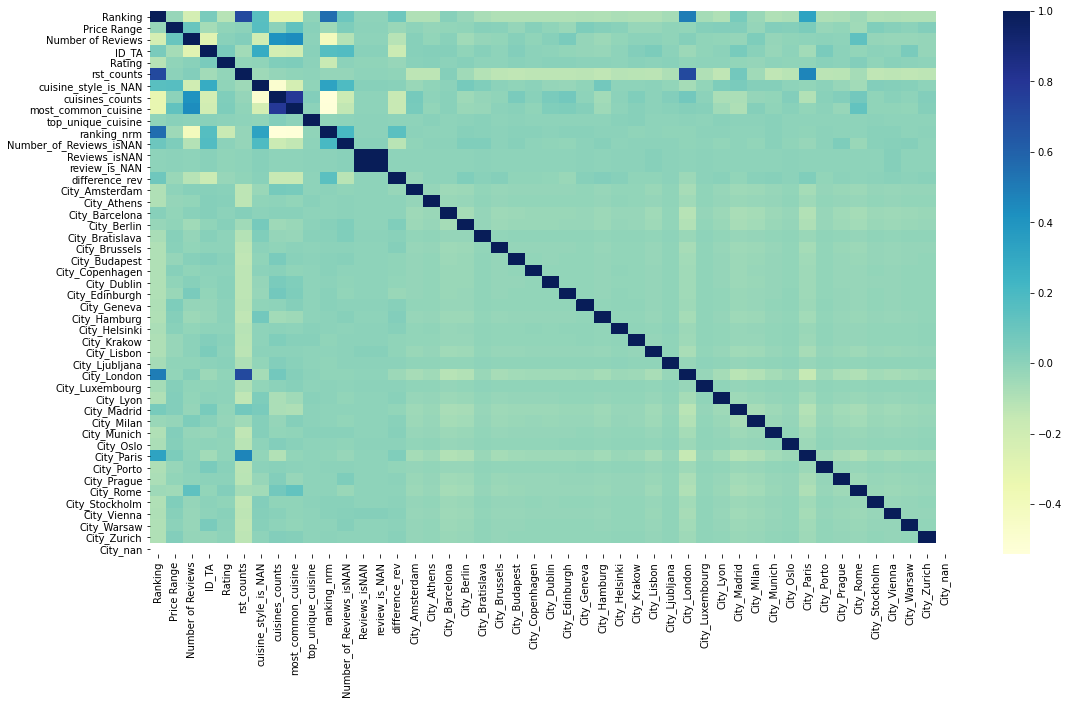

In [87]:
plt.rcParams['figure.figsize'] = (18,10)
sns.heatmap(data.drop(['sample'], axis=1).corr(),cmap = 'YlGnBu')

# Data Preprocessing
Теперь, для удобства и воспроизводимости кода, завернем всю обработку в одну большую функцию.

In [110]:
def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''
    
    df_output = df_input.copy()
    
    # ################### 1. Предобработка ############################################################## 
    # убираем не нужные для модели признаки
    df_output.drop(['Restaurant_id','ID_TA','Cuisine Style', 'Reviews', 'review_dt', 'review_is_NAN'], axis = 1, inplace=True)
    
  
    # ################### 5. Clean #################################################### 
    # убираем признаки которые еще не успели обработать, 
    # модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
    object_columns = [s for s in df_output.columns if df_output[s].dtypes == 'object']
    df_output.drop(object_columns, axis = 1, inplace=True)
    
    return df_output

#### Запускаем и проверяем что получилось

In [90]:
df_preproc = preproc_data(data)
df_preproc.sample(10)

,Ranking,Price Range,Number of Reviews,sample,Rating,rst_counts,cuisine_style_is_NAN,cuisines_counts,most_common_cuisine,top_unique_cuisine,...,City_Oslo,City_Paris,City_Porto,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan
17513,1488.0,2,81.0,1,4.0,1647,0,2,1,0,...,0,0,0,0,0,0,0,0,0,0
11992,1346.0,2,8.0,1,3.5,642,1,1,1,0,...,0,0,1,0,0,0,0,0,0,0
42485,10051.0,2,5.0,1,4.0,6108,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
27112,692.0,2,56.0,1,4.0,1021,0,6,5,0,...,0,0,0,0,0,0,0,0,0,0
43273,2073.0,2,422.0,1,4.0,6108,0,3,3,0,...,0,1,0,0,0,0,0,0,0,0
31870,42.0,2,193.0,1,4.5,1186,0,4,3,0,...,0,0,0,0,0,0,0,0,0,0
22771,1627.0,2,22.0,1,3.5,745,0,3,1,0,...,0,0,0,0,0,0,0,0,0,0
3751,1668.0,2,21.0,0,0.0,1372,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
43391,7901.0,2,42.0,1,3.5,7193,0,4,1,0,...,0,0,0,0,0,0,0,0,0,0
34807,618.0,2,37.0,1,4.0,925,0,3,2,0,...,0,0,0,0,0,0,0,1,0,0


In [91]:
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 46 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Ranking                  50000 non-null  float64
 1   Price Range              50000 non-null  int64  
 2   Number of Reviews        50000 non-null  float64
 3   sample                   50000 non-null  int64  
 4   Rating                   50000 non-null  float64
 5   rst_counts               50000 non-null  int64  
 6   cuisine_style_is_NAN     50000 non-null  uint8  
 7   cuisines_counts          50000 non-null  int64  
 8   most_common_cuisine      50000 non-null  int64  
 9   top_unique_cuisine       50000 non-null  int64  
 10  ranking_nrm              50000 non-null  float64
 11  Number_of_Reviews_isNAN  50000 non-null  uint8  
 12  Reviews_isNAN            50000 non-null  uint8  
 13  difference_rev           50000 non-null  float64
 14  City_Amsterdam        

In [92]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [93]:
# Воспользуемся специальной функцией train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [94]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 45), (40000, 45), (40000, 44), (32000, 44), (8000, 44))

# Model 
Сам ML

In [95]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [96]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [117]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

# # Округлим предсказанные значения до степени округления целевой переменной


def round_rating_pred(rating_pred):
    if rating_pred <= 0.5:
        return 0.0
    if rating_pred <= 1.5:
        return 1.0
    if rating_pred <= 1.75:
        return 1.5
    if rating_pred <= 2.25:
        return 2.0
    if rating_pred <= 2.75:
        return 2.5
    if rating_pred <= 3.25:
        return 3.0
    if rating_pred <= 3.75:
        return 3.5
    if rating_pred <= 4.25:
        return 4.0
    if rating_pred <= 4.75:
        return 4.5
    return 5.0


for i in range(len(y_pred)):
    y_pred[i] = round_rating_pred(y_pred[i])


#for i in range(len(y_train):
    #y_train[i]=round_rating_pred(y_train[i])

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


In [106]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.17575


<AxesSubplot:>

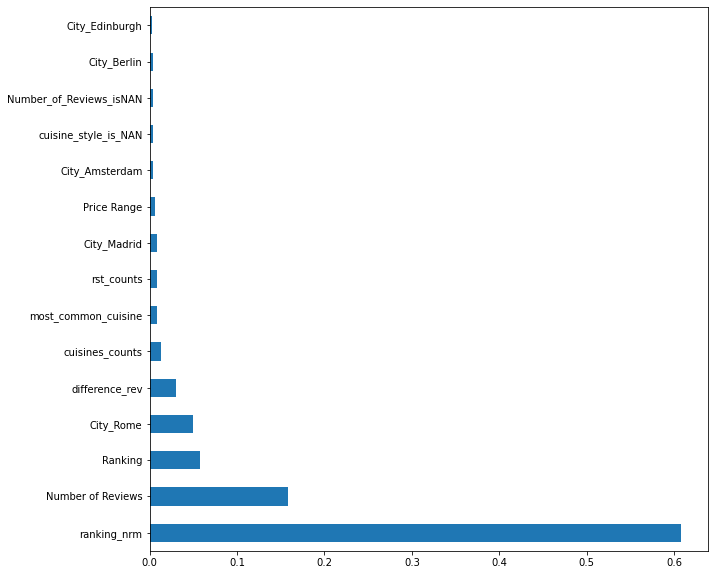

In [99]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

# Submission
Если все устраевает - готовим Submission на кагл

In [100]:
test_data.sample(10)

,Ranking,Price Range,Number of Reviews,Rating,rst_counts,cuisine_style_is_NAN,cuisines_counts,most_common_cuisine,top_unique_cuisine,ranking_nrm,...,City_Oslo,City_Paris,City_Porto,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan
881,5075.0,2,3.0,0.0,2705,1,1,1,0,1.876155,...,0,0,0,0,0,0,0,0,0,0
2569,1527.0,2,4.0,0.0,1021,1,1,1,0,1.495593,...,0,0,0,0,0,0,0,0,0,0
1772,7990.0,2,29.0,0.0,7193,0,3,1,0,1.110802,...,0,0,0,0,0,0,0,0,0,0
4033,63.0,2,64.0,0.0,590,0,6,3,0,0.106780,...,0,0,0,0,0,0,0,0,0,0
2858,2956.0,2,3.0,0.0,1443,0,2,1,0,2.048510,...,0,0,0,0,0,0,1,0,0,0
6780,3636.0,2,1.0,0.0,1647,1,1,1,0,2.207650,...,0,0,0,0,0,0,0,0,0,0
4855,147.0,2,597.0,0.0,2694,0,7,6,0,0.054566,...,0,0,0,0,0,0,0,0,0,0
9319,3859.0,2,12.0,0.0,1816,0,2,1,0,2.125000,...,0,0,0,1,0,0,0,0,0,0
4251,6439.0,2,49.0,0.0,6108,0,1,0,0,1.054191,...,0,1,0,0,0,0,0,0,0,0
9836,3678.0,2,40.0,0.0,6108,0,2,1,0,0.602161,...,0,1,0,0,0,0,0,0,0,0


In [101]:
test_data = test_data.drop(['Rating'], axis=1)

In [102]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [107]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


In [108]:
predict_submission

array([3.04 , 4.23 , 4.5  , ..., 3.07 , 4.505, 4.285])

In [109]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.040
1,id_1,4.230
2,id_2,4.500
3,id_3,4.295
4,id_4,4.445
5,id_5,4.465
6,id_6,2.185
7,id_7,2.235
8,id_8,4.090
9,id_9,4.600
